# Membership Attack to Model of Cifar10 Dataset

In [1]:
import tensorflow as tf
import numpy as np
import os
import dataset_loader
from sklearn.model_selection import train_test_split

In [2]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_reserve = x_train[20000:]
y_reserve = y_train[20000:]
x_train = x_train[:20000]
y_train = y_train[:20000]

In [3]:
print('Train samples:', len(x_train))
print('Test samples:', len(x_test))
print('Reserve Sample:', len(x_reserve))

Train samples: 20000
Test samples: 10000
Reserve Sample: 30000


Now we are going to split the data into 2 disjoints sets:
+ One to train the target model
+ The other to use as data from the same distribution to train our shadow models

In [4]:
x_target_train, x_attack_train, y_target_train, y_attack_train = train_test_split(x_train, y_train, test_size=0.5)
x_target_test, x_attack_test, y_target_test, y_attack_test = train_test_split(x_test, y_test, test_size=0.5)

print('Target Train samples:', len(x_target_train))
print('Target Test samples:', len(x_target_test))
print('Attack Train samples:', len(x_attack_train))
print('Attack Test samples:', len(x_attack_test))

Target Train samples: 10000
Target Test samples: 5000
Attack Train samples: 10000
Attack Test samples: 5000


In [5]:
x_target_train.shape

(10000, 32, 32, 3)

In [204]:
batch_size = 32
num_classes = 10
epochs = 20

#y_target_train = tf.keras.utils.to_categorical(y_target_train, num_classes)
#y_target_test = tf.keras.utils.to_categorical(y_target_test, num_classes)

### Train the target model

In [205]:
target_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:], activation = tf.nn.relu),
    tf.keras.layers.Conv2D(32, (3, 3), activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.Conv2D(64, (3, 3), activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

train_op = tf.optimizers.Adam(1e-4)
target_model.compile(optimizer=train_op,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [235]:
target_model.fit(x_target_train, y_target_train,
              batch_size=batch_size,
              epochs=10,
              validation_data=(x_target_test, y_target_test),
              shuffle=True)

Epoch 1/10
313/313 [==============================] - 32s 103ms/step - loss: 0.2267 - accuracy: 0.9216 - val_loss: 1.4988 - val_accuracy: 0.6300
Epoch 2/10
313/313 [==============================] - 30s 96ms/step - loss: 0.1952 - accuracy: 0.9315 - val_loss: 1.4296 - val_accuracy: 0.6372
Epoch 3/10
313/313 [==============================] - 30s 95ms/step - loss: 0.1902 - accuracy: 0.9368 - val_loss: 1.4619 - val_accuracy: 0.6380
Epoch 4/10
313/313 [==============================] - 31s 98ms/step - loss: 0.1673 - accuracy: 0.9422 - val_loss: 1.5019 - val_accuracy: 0.6402
Epoch 5/10
313/313 [==============================] - 30s 97ms/step - loss: 0.1632 - accuracy: 0.9439 - val_loss: 1.5380 - val_accuracy: 0.6320
Epoch 6/10
313/313 [==============================] - 31s 98ms/step - loss: 0.1535 - accuracy: 0.9478 - val_loss: 1.5053 - val_accuracy: 0.6334
Epoch 7/10
313/313 [==============================] - 31s 98ms/step - loss: 0.1427 - accuracy: 0.9506 - val_loss: 1.5900 - val_accuracy

In [348]:
res_target = target_model.predict_proba(x_target_train)

### Train the Shadow model

In [9]:
import sys
sys.path.append('../')
from mblearn import ShadowModels

In [207]:
shadow_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:], activation = tf.nn.relu),
    tf.keras.layers.Conv2D(32, (3, 3), activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.Conv2D(64, (3, 3), activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

train_op = tf.optimizers.Adam(1e-4)
shadow_model.compile(optimizer=train_op,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [236]:
shm = ShadowModels(x_attack_train,
                   y_attack_train.reshape(1,-1)[0],
                   n_models=10,
                   target_classes=num_classes,
                   learner=shadow_model,
                   epochs=10,
                   batch_size=batch_size,
                   verbose=0)

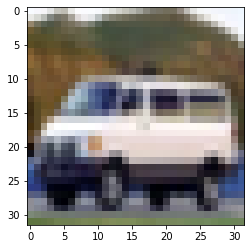

In [12]:
import matplotlib.pyplot as plt
plt.imshow(x_attack_train[0].reshape(32,32,3))

### Train Attack models

In [238]:
from mblearn import AttackModels
from sklearn.ensemble import RandomForestClassifier

In [239]:
rf_attack = RandomForestClassifier(n_estimators=10)

In [240]:
attacker = AttackModels(target_classes=num_classes, attack_learner=rf_attack)

In [241]:
attacker.fit(shm.results)

### Attack for a signal class label

In [257]:
rf = RandomForestClassifier(n_estimators=100)

K = 9
class_label = shm.results[:,-2]

rf.fit(shm.results[:,:-2][class_label == K], shm.results[:,-1][class_label == K])

pr = rf.predict(shm.results[:,:-2][class_label == K])
accuracy_score(pr,shm.results[:,-1][class_label == K])

0.9914438502673797

In [258]:
prr = rf.predict(X_final_test[y_final_test[0] == K])

accuracy_score(Labels_test[y_final_test[0] == K],prr)


0.5657051282051282

In [259]:
precision_score(Labels_test[y_final_test[0] == K],prr)

0.5633802816901409

In [260]:
recall_score(Labels_test[y_final_test[0] == K],prr)

0.14285714285714285

### Create attack test dataset

In [17]:
# construct a set mix up training set and attack set
# feed the set to the target model to get the predict vectors
# feed these vectors to the attack model to get the final result.

In [17]:
_, x_in_test, _, y_in_test = train_test_split(x_target_train, y_target_train, test_size=0.3)
#_, x_out0_test, _, y_out0_test = train_test_split(x_attack_train, y_attack_train, test_size=0.1)
#_, x_out1_test, _, y_out1_test = train_test_split(x_test, y_test, test_size=0.1)
_, x_out2_test, _, y_out2_test = train_test_split(x_reserve, y_reserve, test_size=0.1)

print('In samples:', len(x_in_test))
#print('Out0 samples:', len(x_out0_test))
#print('Out1 samples:', len(x_out1_test))
print('Out2 samples:', len(x_out2_test))

x_final_test = np.vstack((x_in_test, x_out2_test))

y_in_test = y_in_test.reshape(-1,1)
#y_out0_test = y_out0_test.reshape(-1,1)
#y_out1_test = y_out1_test.reshape(-1,1)
y_out2_test = y_out2_test.reshape(-1,1)

y_final_test = np.vstack((y_in_test, y_out2_test)).reshape(1,-1)

Labels_test = np.vstack((np.ones_like(y_in_test), np.zeros_like(y_out2_test)))

#Final_test = np.hstack((X_final_test,y_final_test))

In samples: 3000
Out2 samples: 3000


In [242]:
X_final_test = target_model.predict_proba(x_final_test)

### The shadow model's preformance?

In [139]:
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [243]:
predict_prob = attacker.predict(shm.results[:,:-2],shm.results[:,-2].astype(int),batch=True)
predict_prob = np.array(predict_prob)[:,0]

In [244]:
result = shm.results[:,:-2]

label_results = []
for i in range(result.shape[0]):
    label_results.append(list(result[i]).index(max(result[i])))

In [245]:
label_results = np.array(label_results)

accuracy_score(label_results,shm.results[:,-2])

0.8361809045226131

In [246]:
predict = predict_prob[:,0] < predict_prob[:,1]
predict = predict.astype(int)

cross_entropy = log_loss(shm.results[:,-1], predict_prob)
accuracy = accuracy_score(shm.results[:,-1], predict)
precision = precision_score(shm.results[:,-1], predict)
recall = recall_score(shm.results[:,-1], predict)

print('cross_entropy:', cross_entropy)
print('accuracy:', accuracy)
print('precision:', precision)
print('recall:',recall)

cross_entropy: 0.1494322870270706
accuracy: 0.9845226130653266
precision: 0.9884381338742394
recall: 0.9804828973843058


### Final Test 

In [247]:
predict_prob = attacker.predict(X_final_test,y_final_test[0],batch=True)
predict_prob = np.array(predict_prob)[:,0]

In [248]:
predict = predict_prob[:,0] < predict_prob[:,1]
predict = predict.astype(int)

In [249]:
cross_entropy = log_loss(Labels_test,predict_prob)

accuracy = accuracy_score(Labels_test,predict)
precision = precision_score(Labels_test,predict)
recall = recall_score(Labels_test,predict)

print('cross_entropy:', cross_entropy)
print('accuracy:', accuracy)
print('precision:', precision)
print('recall:',recall)

cross_entropy: 1.122397504671161
accuracy: 0.7091666666666666
precision: 0.7190226876090751
recall: 0.6866666666666666
